# Graph Generator

In [1]:
import os
import itertools
from collections import Counter

from imports import *
from linkpred import *
from dataset import *
from torch_geometric.utils import remove_self_loops

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')
%matplotlib inline

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

/home/gavin/anaconda3/envs/pygeo/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## set random seeds
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [3]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

1.5.1
device = cuda


## Load the Dataset

load the node attribute matrix

In [4]:
node_attributes = pd.read_csv('data/NDSSL data/raw/node_attributes.csv')
node_attributes.head(5)

,person_id,household_id,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,2509159,2201175,42,1,1,1,13,3,97201,3,2
1,2509160,2201175,43,2,1,1,13,3,97201,3,2
2,2509161,2201175,17,1,2,2,13,3,97201,3,2
3,2509162,2201176,41,1,1,1,11,2,97201,3,1
4,2509163,2201176,11,1,2,2,11,2,97201,3,1


In [5]:
data_columns = ['age', 'gender', 'worker', 'relationship', 'household_income', 'household_size', 'zipcode', 'household_vehicles', 'household_workers']
discrete_columns = ['age', 'gender', 'worker', 'relationship', 'household_income', 'household_size', 'zipcode', 'household_vehicles', 'household_workers']
node_attributes[data_columns].head(5)

,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,42,1,1,1,13,3,97201,3,2
1,43,2,1,1,13,3,97201,3,2
2,17,1,2,2,13,3,97201,3,2
3,41,1,1,1,11,2,97201,3,1
4,11,1,2,2,11,2,97201,3,1


load the NDSSL network

In [6]:
ndssl = load_dataset(dataset_name='NDSSL')
data_ndssl = ndssl[0]

G_real = nx.Graph()
G_real.add_edges_from(tuple(map(tuple, np.transpose(data_ndssl.edge_index.numpy()))))
degree_sequence = np.asarray(sorted([d for n, d in G_real.degree()], reverse=False))
degree_counter = Counter(degree_sequence)

## Generate Node Attribute Matrix Using CTGAN

Use CTGAN ([paper](https://arxiv.org/abs/1907.00503), [code](https://github.com/sdv-dev/CTGAN)) to learn a generative model over the marginal distribution $P(X)$. Once this is trained, generate a new sample of $X$.

In [7]:
epochs = 300
n = 100000
save_path = 'generated/df_artificial_n_' + str(n) + '_ctgan_epochs_' + str(epochs) + '.pt'

# load a previously generated node attribute matrix
if os.path.exists(save_path):
    print('loading previously generated node attribute matrix')
    df_artificial = pd.read_pickle(save_path)

#or generate it for the first time
else:
    # load the CTGAN model
    from ctgan import CTGANSynthesizer
    # train from scratch
    if not os.path.exists('weights/ctgan_epoch_' + str(epochs)):
        print('training CTGAN from scratch')        
        ctgan = CTGANSynthesizer()
        ctgan.fit(node_attributes[data_columns], discrete_columns, epochs=epochs)
        torch.save(ctgan.generator.state_dict(), 'weights/ctgan_epoch_' + str(epochs))
    # load pre-trained model
    else:
        print('generating node attribute matrix from pre-trained CTGAN')        
        ctgan = CTGANSynthesizer()
        ctgan.fit(node_attributes[data_columns], discrete_columns, epochs=0) #this initializes the CTGAN
        ctgan.generator.load_state_dict(torch.load('weights/ctgan_epoch_' + str(epochs)))
        
    # generate artificial node feature matrix
    df_artificial = ctgan.sample(n)
    
    # save
    df_artificial.to_pickle(save_path)

generating node attribute matrix from pre-trained CTGAN


In [8]:
df_artificial.head(5)

,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,19,2,1,1,13,4,97216,3,2
1,33,2,1,1,9,5,98662,2,2
2,83,2,2,1,12,2,97080,1,0
3,4,2,2,2,6,4,97266,2,2
4,10,1,2,2,13,6,97034,5,3


Compare the marginals of the synthetic data to the true marginals from the NDSSL data:

Note that these histograms for the household variables in the real, NDSSL data look a bit different than the histograms in the appendix. This is because here we are looking at the household variables on a per individual basis, whereas there we looked at the household variables on a per household basis. 

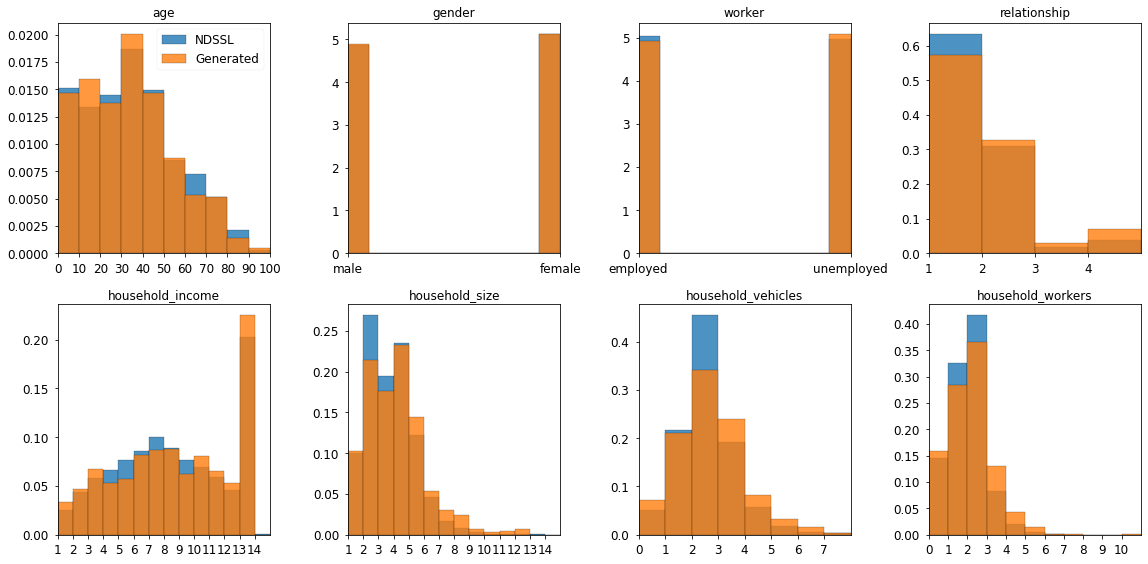

In [9]:
alpha = 0.8

fig, axarr = plt.subplots(2, 4, figsize=(16,8))
fig.subplots_adjust(wspace=0.3)

## age
bins = [0,10,20,30,40,50,60,70,80,90,100]
axarr[0,0].hist(node_attributes['age'].values, density=True, bins=bins, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[0,0].hist(df_artificial['age'].values, density=True, bins=bins, edgecolor='black', alpha=alpha, label='Generated')
axarr[0,0].set_title('age')
#bins = np.arange(1, node_attributes['age'].values.max() + 0.5) - 0.5
axarr[0,0].set_xticks(bins)
axarr[0,0].set_xlim([0, 100])
axarr[0,0].legend()

## gender
bins = np.arange(node_attributes['gender'].values.min(), node_attributes['gender'].values.max() + 1)
axarr[0,1].hist(node_attributes['gender'].values, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[0,1].hist(df_artificial['gender'].values, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[0,1].set_title('gender')
axarr[0,1].set_xticks(bins)
axarr[0,1].set_xticklabels(['male', 'female'])
axarr[0,1].set_xlim([node_attributes['gender'].values.min(), node_attributes['gender'].values.max()])
#axarr[0,1].legend()

## worker
bins = np.arange(node_attributes['worker'].values.min(), node_attributes['worker'].values.max() + 1)
axarr[0,2].hist(node_attributes['worker'].values, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[0,2].hist(df_artificial['worker'].values, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[0,2].set_title('worker')
axarr[0,2].set_xticks(bins)
axarr[0,2].set_xticklabels(['employed', 'unemployed'])
axarr[0,2].set_xlim([node_attributes['worker'].values.min(), node_attributes['worker'].values.max()])
#axarr[0,2].legend()

## relationship
bins = np.arange(node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max() + 2)
axarr[0,3].hist(node_attributes['relationship'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[0,3].hist(df_artificial['relationship'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[0,3].set_title('relationship')
axarr[0,3].set_xticks(bins[0:-1])
axarr[0,3].set_xlim([node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max()+1])
#axarr[0,3].legend()

## household_income
bins = np.arange(node_attributes['household_income'].values.min(), node_attributes['household_income'].values.max() + 2)
axarr[1,0].hist(node_attributes['household_income'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[1,0].hist(df_artificial['household_income'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[1,0].set_title('household_income')
axarr[1,0].set_xticks(bins[:-1])
axarr[1,0].set_xlim([node_attributes['household_income'].values.min(), node_attributes['household_income'].values.max()+1])
#axarr[1,0].legend()

## household_size
bins = np.arange(node_attributes['household_size'].values.min(), node_attributes['household_size'].values.max() + 2)
axarr[1,1].hist(node_attributes['household_size'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[1,1].hist(df_artificial['household_size'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[1,1].set_title('household_size')
axarr[1,1].set_xticks(bins[:-1])
axarr[1,1].set_xlim([node_attributes['household_size'].values.min(), node_attributes['household_size'].values.max()+1])
#axarr[1,1].legend()

## household_vehicles
bins = np.arange(node_attributes['household_vehicles'].values.min(), node_attributes['household_vehicles'].values.max() + 2)
axarr[1,2].hist(node_attributes['household_vehicles'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[1,2].hist(df_artificial['household_vehicles'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[1,2].set_title('household_vehicles')
axarr[1,2].set_xticks(bins[:-1])
axarr[1,2].set_xlim([node_attributes['household_vehicles'].values.min(), node_attributes['household_vehicles'].values.max()+1])
#axarr[1,2].legend()

## household_workers
bins = np.arange(node_attributes['household_workers'].values.min(), node_attributes['household_workers'].values.max() + 2)
axarr[1,3].hist(node_attributes['household_workers'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='NDSSL')
axarr[1,3].hist(df_artificial['household_workers'].values, bins=bins, density=True, edgecolor='black', alpha=alpha, label='Generated')
axarr[1,3].set_title('household_workers')
axarr[1,3].set_xticks(bins[:-1])
axarr[1,3].set_xlim([node_attributes['household_workers'].values.min(), node_attributes['household_workers'].values.max()+1])
#axarr[1,3].legend()

plt.tight_layout()

# shift subplots down:
#st.set_y(1)
#fig.subplots_adjust(top=0.85)

## save and display
save_path = 'figures/ctgan_vs_ndssl_histograms_n_' + str(n) + '_ctgan_epochs_' + str(epochs) + '.pdf'
plt.savefig(save_path, bbox_inches='tight')
plt.show()

## Initialize Random Graph

Generate a new dataset corresponding to the generated X matrix and a randomly initialized edge list. We explored a number of options for initializing the graph:
1. A scale-free graph with $n$ nodes
2. An Erdos-Renyi G(N,M) graph with M chosen according to:
    - keeping the density of the generated graph to be the same as in NDSSL
    - keeping the edge/node ratio of the generated graph to be the same as in NDSSL
    - to allow for a fractional scaling, i.e. 
    $$ M_{Gen} = M_{NDSSL} \left( \frac{N_{Gen}}{N_{NDSSL}} \right)^{\nu} $$
3. A Watts-Strogatz small-world network

In [10]:
#init_type = 'scale-free'
#init_type = 'const-density'
init_type = 'const-edge-node-ratio'
#init_type = 'fractional scaling'
#init_type = 'small-world'

fraction = 1.03 #only used for the fractional scaling 
k, p = 10, 0.5 #small-world parameters

In [11]:
save_path = 'generated/edge_index_initial_' + init_type + '_n_' + str(n) + '.pt'

# load a previously generated initial edge list or generate it for the first time
if os.path.exists(save_path):    
    print('loading previously generated initial edge list')
    edge_index_initial = torch.load(save_path)
else:
    if init_type == 'scale-free':
        # initialize as a BA scale-free network with n nodes
        print('initializing as scale-free')    
        G_generated_initial = nx.scale_free_graph(n)

        edge_index_initial = []
        for edge in G_generated_initial.edges.data():
            edge_index_initial.append([edge[0], edge[1]])
        edge_index_initial = np.transpose(np.asarray(edge_index_initial))
        edge_index_initial = torch.LongTensor(edge_index_initial)

    elif init_type == 'const-density':
        # initialize as an ER graph with the same density as NDSSL
        print('initializing as ER with constant density')    
        ndssl_density = nx.density(G_real)
        num_edges = int((n**2/2)*ndssl_density)
        edge_index_initial = torch.sort(torch.randint(low=0, high=n, size=(2, num_edges)), 0)[0]
        edge_index_initial, _ = remove_self_loops(edge_index_initial) #remove any self-loops

    elif init_type == 'const-edge-node-ratio':
        print('initializing as ER with constant M/N ratio')
        # initialize as an ER graph with the same edge/node ratio as NDSSL
        ndssl_edge_to_node_ratio = G_real.number_of_edges()/G_real.number_of_nodes()
        num_edges = int(ndssl_edge_to_node_ratio * n)
        edge_index_initial = torch.sort(torch.randint(low=0, high=n, size=(2, num_edges)), 0)[0]
        edge_index_initial, _ = remove_self_loops(edge_index_initial) #remove any self-loops

    elif init_type == 'fractional scaling':
        print('initializing as ER with M given by fractional scaling')
        # initialize as an ER graph with M ~ M_0*(N/N_0)^(3/2)
        # with N_0, M_0 the number of nodes, edges in NDSSL
        num_edges = int(G_real.number_of_edges()*(n/len(node_attributes)**(fraction)))
        edge_index_initial = torch.sort(torch.randint(low=0, high=n, size=(2, num_edges)), 0)[0]
        edge_index_initial, _ = remove_self_loops(edge_index_initial) #remove any self-loops

    elif init_type == 'small-world':
        # initialize as a (connected) small-world network
        print('initializing as small-world')
        G_generated_initial = nx.connected_watts_strogatz_graph(n=n, k=k, p=p, seed=123)

        edge_index_initial = []
        for edge in G_generated_initial.edges.data():
            edge_index_initial.append([edge[0], edge[1]])
        edge_index_initial = np.transpose(np.asarray(edge_index_initial))
        edge_index_initial = torch.LongTensor(edge_index_initial)

    torch.save(edge_index_initial, save_path)

data = Data(x=dataframe2onehot(df_artificial, node_attributes), edge_index=edge_index_initial, edge_attr=None, y=torch.arange(0, len(df_artificial)))
row, col = data.edge_index
data.edge_attr = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.

initializing as ER with constant M/N ratio


In [12]:
print('number of nodes: %i' %data.num_nodes)
print('number of edges: %i' %data.num_edges)

number of nodes: 100000
number of edges: 1236242


In [13]:
data.x.shape[1]

143

N.B. To avoid complications associated with the GraphSAINT sampler, here we are working with $n$ small enough to allow for the entire graph to be fit on the GPU. Larger values of $n$ will require that the GraphSAINT sampler is used. One technical issue is that the GraphSAINT sampler returns a batch of nodes and edges that are re-indexed, which then poses an obstacle for updating the full graph based on the re-wirings of a small batch of edges. To surmount this, I used the fact that in link prediction there is no y-variable, and I therefore used this "wasted variable" to store the node id information. This may become useful in future implementations, but it is not used at all here.

## Graph Generation by Iterated Link Prediction (Graph GILP)

Load the Link Predictor Model

In [14]:
linkpred_epochs = 600
model = Net(num_node_features=data.x.shape[1], hidden_channels=256, embed_dim=64).to(device)
model.load_state_dict(torch.load('weights/link_predictor_epoch_' + str(linkpred_epochs)))
model.eval()
model.set_aggr('mean')

Run the main algorithm

In [15]:
batch_size = 100000
rewire_strategy = 'sample'
threshold = 0.5
N_outer = 100000
N_inner = 1

num_edges_target = data.num_edges
add_delete_record = {'iter':[], 'type':[], 'edits':[], 'edges':[]}
count = 0
with torch.no_grad():
    
    for i in tqdm(range(N_outer)):
        
        z = model(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device))

        for j in range(N_inner):

            count += 1
            add_delete_record['iter'].append(count)
            
            # delete edges
            if data.num_edges > num_edges_target:
                pos_edges_index = torch.randint(low=0, high=data.num_edges, size=(batch_size, ))
                pos_edges_batch = data.edge_index[:,pos_edges_index]
                probs = model.pij(z, pos_edges_batch)

                if rewire_strategy == 'sample':
                    sampled_probs = probs > torch.rand(batch_size).to(device)
                else:
                    sampled_probs = probs > threshold

                # update edges and edge weights                    
                edges_to_be_removed_index = pos_edges_index[~sampled_probs]
                data.edge_index = torch.LongTensor(np.delete(data.edge_index.numpy(), edges_to_be_removed_index.numpy(), 1))                
                row, col = data.edge_index
                data.edge_attr = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.
                
                # log results
                add_delete_record['type'].append('delete')
                add_delete_record['edits'].append(edges_to_be_removed_index.shape[0])
    
            # add edges
            else:
                neg_edges_batch = torch.sort(torch.randint(low=0, high=n, size=(2, batch_size)), 0)[0]
                probs = model.pij(z, neg_edges_batch)

                if rewire_strategy == 'sample':
                    sampled_probs = probs > torch.rand(batch_size).to(device)                
                else:
                    sampled_probs = probs > threshold              
                    
                # update edges and edge weights
                data.edge_index = torch.cat((data.edge_index, neg_edges_batch[:,sampled_probs]), axis=1)
                row, col = data.edge_index
                data.edge_attr = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.

                # log results
                add_delete_record['type'].append('add')
                add_delete_record['edits'].append(neg_edges_batch[:, sampled_probs].shape[1])
               
            add_delete_record['edges'].append(data.num_edges)

# clean-up
add_delete_record['iter'] = np.asarray(add_delete_record['iter'])
add_delete_record['type'] = np.asarray(add_delete_record['type'])
add_delete_record['edits'] = np.asarray(add_delete_record['edits'])
add_delete_record['edges'] = np.asarray(add_delete_record['edges'])

# save edge list
save_path = 'generated/edge_index_final_' + init_type + '_n_' + str(n) + '_ctgan_epochs_' + str(epochs) \
    + '_iterations_' + str(N_outer) + '_linkpred_epochs_' + str(linkpred_epochs) + '.pt'
torch.save(data.edge_index, save_path)

# save add_delete_record
save_path = 'generated/add_delete_record_' + init_type + '_n_' + str(n) + '_ctgan_epochs_' + str(epochs) \
    + '_iterations_' + str(N_outer) + '_linkpred_epochs_' + str(linkpred_epochs) + '.pt'
np.save(save_path, add_delete_record) 

## Analysis

In [16]:
print('number of add steps: %i' %np.sum(add_delete_record['type'] == 'add'))
print('number of delete steps: %i' %np.sum(add_delete_record['type'] == 'delete'))
print('add/delete ratio: %.2f' %\
      (np.sum(add_delete_record['type'] == 'add')/np.sum(add_delete_record['type'] == 'delete')))

number of add steps: 12045
number of delete steps: 87955
add/delete ratio: 0.14


In [17]:
edges_added = np.sum(add_delete_record['edits'][add_delete_record['type'] == 'add'])
edges_deleted = np.sum(add_delete_record['edits'][add_delete_record['type'] == 'delete']) 

print('edges added = %.2e' %edges_added)
print('edges deleted = %.2e' %edges_deleted)

edges added = 6.08e+08
edges deleted = 6.13e+08


In [18]:
print('added edges/M = %.2f' %(edges_added/data.num_edges))
print('deleted edges/M = %.2f' %(edges_deleted/data.num_edges))

added edges/M = 491.11
deleted edges/M = 495.22


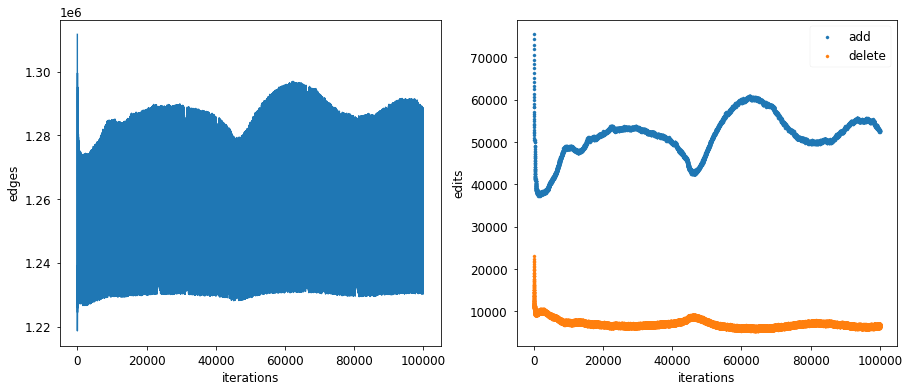

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(add_delete_record['iter'], add_delete_record['edges'])
ax[0].set_xlabel('iterations')
ax[0].set_ylabel('edges')
#ax[0].set_xscale('log')

s = 10
ax[1].scatter(add_delete_record['iter'][add_delete_record['type'] == 'add'], \
         add_delete_record['edits'][add_delete_record['type'] == 'add'], label='add', s=s)
ax[1].scatter(add_delete_record['iter'][add_delete_record['type'] == 'delete'], \
         add_delete_record['edits'][add_delete_record['type'] == 'delete'], label='delete', s=s)
ax[1].legend()
ax[1].set_xlabel('iterations')
ax[1].set_ylabel('edits')
#ax[1].set_xscale('log')

save_suffix =  init_type + '_n_' + str(n) + '_ctgan_epochs_' + str(epochs) \
    + '_iterations_' + str(N_outer) + 'linkpred_epochs' + str(linkpred_epochs)

plt.savefig('figures/graph_generation_history_' + save_suffix + '.pdf')
plt.show()

In [20]:
G_generated_initial = nx.Graph()
G_generated_initial.add_edges_from(tuple(map(tuple, np.transpose(edge_index_initial.numpy()))))
degree_sequence_generated_initial = np.asarray(sorted([d for n, d in G_generated_initial.degree()], reverse=False))
degree_counter_generated_initial = Counter(degree_sequence_generated_initial)

In [21]:
G_generated = nx.Graph()
G_generated.add_edges_from(tuple(map(tuple, np.transpose(data.edge_index.numpy()))))
degree_sequence_generated = np.asarray(sorted([d for n, d in G_generated.degree()], reverse=False))
degree_counter_generated = Counter(degree_sequence_generated)

In [22]:
print('Real Graph\n--------------------')
print('number of nodes: %i '% G_real.number_of_nodes())
print('number of edges: %i '% G_real.number_of_edges())
print('density: %.2e'% nx.density(G_real))
#print('triangles: %i' %(np.sum(list(nx.triangles(G_real).values()))))
print('triangles: %i' %(388850385))

print('\n')

print('Initial Generated Graph\n--------------------')
print('number of nodes: %i '% G_generated_initial.number_of_nodes())
print('number of edges: %i '% G_generated_initial.number_of_edges())
print('density: %.2e'% nx.density(G_generated_initial))
print('triangles: %i' %(np.sum(list(nx.triangles(G_generated_initial).values()))))
print('\n')

print('Generated Graph\n--------------------')
print('number of nodes: %i '% G_generated.number_of_nodes())
print('number of edges: %i '% G_generated.number_of_edges())
print('density: %.2e'% nx.density(G_generated))
print('triangles: %i' %(np.sum(list(nx.triangles(G_generated).values()))))

Real Graph
--------------------
number of nodes: 1575861 
number of edges: 19481626 
density: 1.57e-05
triangles: 388850385


Initial Generated Graph
--------------------
number of nodes: 100000 
number of edges: 1236104 
density: 2.47e-04
triangles: 7680


Generated Graph
--------------------
number of nodes: 87894 
number of edges: 1238215 
density: 3.21e-04
triangles: 25767


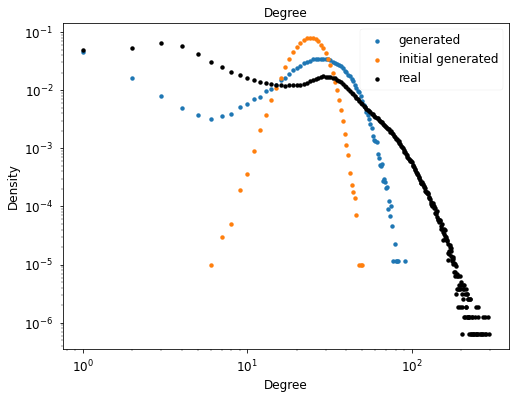

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
s = 6

degree_values = np.asarray(list(degree_counter_generated.values()))
degree_values = degree_values/np.sum(degree_values)
plt.scatter(list(degree_counter_generated.keys()), degree_values, alpha=1, linewidth=2, s=s, marker='o', label='generated')

degree_values = np.asarray(list(degree_counter_generated_initial.values()))
degree_values = degree_values/np.sum(degree_values)
plt.scatter(list(degree_counter_generated_initial.keys()), degree_values, alpha=1, linewidth=2, s=s, marker='o', label='initial generated')

degree_values = np.asarray(list(degree_counter.values()))
degree_values = degree_values/np.sum(degree_values)
plt.scatter(list(degree_counter.keys()), degree_values, alpha=1, linewidth=2, s=s, marker='o', label='real', color='k')

plt.xscale('log')
plt.yscale('log')
plt.title("Degree")
plt.ylabel("Density")
plt.xlabel("Degree")
plt.legend()
#plt.savefig('figures/graph_generation_degree.pdf')
plt.show()

look at triangles, other measures (what could these be?)
mixing ratios

## Demonstrate convergence of XXX [name?]

n = 100
df_artificial = ctgan.sample(n)

edge_list = []
for pair in itertools.combinations(np.arange(n),2):
    edge_list.append(np.asarray(pair))
edge_list = torch.LongTensor(np.transpose(np.asarray(edge_list)))

data = Data(x=dataframe2onehot(df_artificial, node_attributes), edge_index=edge_list, edge_attr=None, y=torch.arange(0, len(df_artificial)))
data.edge_attr = torch.rand(data.edge_index.shape[1])

data.to(device)

L2error = []
niter = 100

with torch.no_grad():
    
    for i in range(niter):
        z = model(data.x, data.edge_index, data.edge_attr)
        edge_attr_new = model.pij(z, data.edge_index).clone()
        L2error.append(torch.mean(torch.square(edge_attr_new - data.edge_attr)).cpu().item())
        data.edge_attr = edge_attr_new.clone()

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.arange(niter), L2error)
plt.xlabel('iterations')
plt.yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(edge_attr_new.cpu().numpy())
plt.show()